# State Farm Distracted Driver Detection - Individual Project (JGS)

Dataset used for this individual project can be downloaded from Kaggle
https://www.kaggle.com/c/state-farm-distracted-driver-detection/overview

In [1]:
import os
import shutil
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

Init Plugin
Init Graph Optimizer
Init Kernel


## 1) Data Wrangling

Setup the data folder and check if the number of examples (files) matches with the information on the CSV file.

In [2]:
# Set this variable to the root folder of the State Farm Distratec Driver Detection Data
local_data = "/Users/gil/Downloads/state-farm-distracted-driver-detection"

In [3]:
# Load the Driver, Class, Image CSV file into a panda
df_image_class = pd.read_csv(os.path.join(local_data, "driver_imgs_list.csv"))
df_image_class.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


The number of training examples is:  22424
The number of unique image filenames is:  22424
The number of examples per class is: 

c0    2489
c1    2267
c2    2317
c3    2346
c4    2326
c5    2312
c6    2325
c7    2002
c8    1911
c9    2129
Name: classname, dtype: int64


<AxesSubplot:>

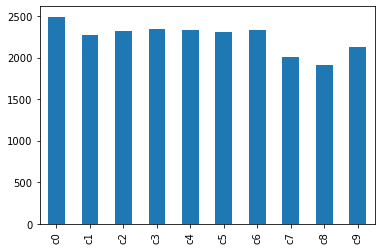

In [5]:
print("The number of training examples is: ", df_image_class.shape[0])

# Let's check if there are 22424 unique examples

print("The number of unique image filenames is: ", len(df_image_class["img"].unique()))

# Let's check the number of examples per class
print("The number of examples per class is: \n")
print(df_image_class["classname"].value_counts(sort=False))
df_image_class["classname"].value_counts(sort=False).plot.bar()

It seems like the data is well balanced (around the same amount of examples per class). Let's now check if the files actually match the info on the CSV file.

In [6]:
for i in range(10):
    print(
        f"Number of c{i} files: ",
        len(os.listdir(os.path.join(local_data, f"imgs/train/c{i}"))),
    )

Number of c0 files:  2489
Number of c1 files:  2267
Number of c2 files:  2317
Number of c3 files:  2346
Number of c4 files:  2326
Number of c5 files:  2312
Number of c6 files:  2325
Number of c7 files:  2002
Number of c8 files:  1911
Number of c9 files:  2129


***All the numbers seem to match! So we are all set to start spliting between Train and Validation sets.***

## Training/Validation split

We are going to split the original training data between training and validation sets

In [23]:
# Using os.mkdir to create the directories for training and validation sets inside our local_data path
# Then we create subdirectories for each class inside the training and validation folders

try:
    os.mkdir(os.path.join(local_data, "training"))
    os.mkdir(os.path.join(local_data, "validation"))
    for i in range(10):
        os.mkdir(os.path.join(local_data, f"training/c{i}"))
        os.mkdir(os.path.join(local_data, f"validation/c{i}"))
except OSError:
    pass

In [4]:
# Writing a split_data function that takes
# a path to the SOURCE directory containing the files
# a path to the TRAINING directory that will hold the training files
# a path to the VALIDATION directory that will hold the validation files
# a SPLIT SIZE to determine the portion

# We'll also randomized the files so that the training set is a random
# % of the files and the validation set is the remaining files
# For example, if SOURCE is img/train/c0 and SPLIT SIZE is .9
# Then 90% of the images in img/train/c0 will be copied to the TRAINING folder
# and 10% of the images will be copied to the VALIDATION folder
# We are also going to check the size of all images and if they have a zero
# file length,they will not be copied over


def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):

    random_source = random.sample(os.listdir(SOURCE), len(os.listdir(SOURCE)))
    n_training_files = n_validation_files = n_zero_length_files = 0

    for i, source_file in enumerate(random_source):
        if i < SPLIT_SIZE * len(random_source):
            if os.path.getsize(os.path.join(SOURCE, source_file)) != 0:
                shutil.copyfile(
                    os.path.join(SOURCE, source_file),
                    os.path.join(TRAINING, source_file),
                )
                n_training_files += 1
            else:
                print(f"File {source_file} is zero lengh so we don't copy it")
                n_zero_length_files += 1
        else:
            if os.path.getsize(os.path.join(SOURCE, source_file)) != 0:
                shutil.copyfile(
                    os.path.join(SOURCE, source_file),
                    os.path.join(VALIDATION, source_file),
                )
                n_validation_files += 1
            else:
                print(f"File {source_file} is zero lengh so we don't copy it")
                n_zero_length_files += 1

    print("\nNumber of total files processed: ", i + 1)
    print("Number of zero length files found: ", n_zero_length_files)
    print("Number of files copied to training directory: ", n_training_files)
    print("Number of files copied to validation directory: ", n_validation_files)

In [24]:
# Now we call the split_data function passing the different SOURCE, TRAINING
# and VALIDATION paths to every class

# Let's set the split size as 90% to training and 10% to validation
split_size = 0.9

# Use a forloop to go over the 10 classes c0 to c9 and split the data
for i in range(10):
    source = os.path.join(local_data, f"imgs/train/c{i}")
    training = os.path.join(local_data, f"training/c{i}")
    validation = os.path.join(local_data, f"validation/c{i}")
    print(f"\nFor class c{i} with have the following:")
    split_data(source, training, validation, split_size)


For class c0 with have the following:

Number of total files processed:  2489
Number of zero length files found:  0
Number of files copied to training directory:  2241
Number of files copied to validation directory:  248

For class c1 with have the following:

Number of total files processed:  2267
Number of zero length files found:  0
Number of files copied to training directory:  2041
Number of files copied to validation directory:  226

For class c2 with have the following:

Number of total files processed:  2317
Number of zero length files found:  0
Number of files copied to training directory:  2086
Number of files copied to validation directory:  231

For class c3 with have the following:

Number of total files processed:  2346
Number of zero length files found:  0
Number of files copied to training directory:  2112
Number of files copied to validation directory:  234

For class c4 with have the following:

Number of total files processed:  2326
Number of zero length files found

***Now we are ready to start playing with some models!!***

## 2) Creating a ImageDataGenerator for our training and validation images
We'll use these generators to feed our tensorflow models. We'll also use it to normalize the input images and to implement data augmentation on the training data.

Defining the input image size as 300x300. Later we'll experiment with different sizes. The original image size is 640x480.

In [5]:
# Creating the ImageDataGenerator for the training data
TRAINING_DIR = os.path.join(local_data, "training")
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR, target_size=(320, 240), batch_size=100, class_mode="categorical"
)

# Creating the ImageDataGenerator for the validation data
VALIDATION_DIR = os.path.join(local_data, "validation")
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR, target_size=(320, 240), batch_size=100, class_mode="categorical"
)

Found 20187 images belonging to 10 classes.
Found 2237 images belonging to 10 classes.


## 3) Let's create a simple CNN to start playing around with this dataset!

In [6]:
# Defining a keral model with 5 Convolutational Layers followed by MaxPooling
# One dense layer with 512 neurons
# One output softmax layer with 10 neurons to predict the classes

first_model = tf.keras.models.Sequential(
    [
        # First CONV + Pool layers
        tf.keras.layers.Conv2D(
            16, (3, 3), activation="relu", input_shape=(320, 240, 3)
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Second CONV + Pool layers
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Third CONV + Pool layers
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Forth CONV + Pool layers
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Fifth CONV + Pool layers
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten to feed into the Dense NN
        tf.keras.layers.Flatten(),
        # First Dense layer with 512 neurons
        tf.keras.layers.Dense(512, activation="relu"),
        # Output layer with 10 neurons
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

first_model.compile(
    optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

Metal device set to: Apple M1


2021-07-14 21:33:54.635803: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-07-14 21:33:54.636351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
first_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 318, 238, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 159, 119, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 157, 117, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 78, 58, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 76, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 38, 28, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 36, 26, 64)       

In [7]:
# Let's train the model for 40 epochs and see how it performs
# If you don't want to train the model just run the cell below
# marked as "Load First Model" to load the pretrained model
history = first_model.fit(train_generator,
                              epochs=40,
                              verbose=1,
                              validation_data=validation_generator)

2021-07-14 21:34:04.803210: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-14 21:34:04.804338: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-07-14 21:34:04.959378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/40
202/202 [==============================] - ETA: 0s - loss: 2.2893 - accuracy: 0.1209

2021-07-14 21:37:17.799979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


202/202 [==============================] - 199s 980ms/step - loss: 2.2893 - accuracy: 0.1209 - val_loss: 2.1703 - val_accuracy: 0.2052
Epoch 2/40
202/202 [==============================] - 199s 982ms/step - loss: 1.9484 - accuracy: 0.2749 - val_loss: 1.6860 - val_accuracy: 0.3330
Epoch 3/40
202/202 [==============================] - 201s 992ms/step - loss: 1.5660 - accuracy: 0.4128 - val_loss: 1.1222 - val_accuracy: 0.5977
Epoch 4/40
202/202 [==============================] - 199s 982ms/step - loss: 1.2692 - accuracy: 0.5375 - val_loss: 0.9512 - val_accuracy: 0.6428
Epoch 5/40
202/202 [==============================] - 202s 992ms/step - loss: 1.0189 - accuracy: 0.6435 - val_loss: 0.7437 - val_accuracy: 0.7273
Epoch 6/40
202/202 [==============================] - 201s 993ms/step - loss: 0.8343 - accuracy: 0.7145 - val_loss: 0.5375 - val_accuracy: 0.8002
Epoch 7/40
202/202 [==============================] - 200s 989ms/step - loss: 0.7074 - accuracy: 0.7572 - val_loss: 0.5451 - val_accura

In [8]:
# Get the project directory in other to save the model
project_folder = os.getcwd()
print(project_folder)

/Users/gil/Documents/Cursos/FourthBrain/Projects/State_Farm


In [9]:
# Let's save the first model trained for 40 epochs
first_model.save(os.path.join(project_folder, "first_model/40"))

2021-07-15 14:14:39.995009: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/gil/Documents/Cursos/FourthBrain/Projects/State_Farm/first_model/40/assets


In [175]:
import seaborn as sns

# Get the results on the training and validation data sets
# for each training epoch and stack them together in columns
results_first_model = np.vstack(
    (
        history.history["accuracy"],
        history.history["val_accuracy"],
        history.history["loss"],
        history.history["val_loss"],
    )
).T

# Create a Panda Dataframe from the first model results
history_first_model_pd = pd.DataFrame(
    {
        "Epochs": range(1, results_first_model.shape[0] + 1),
        "Training Accuracy": results_first_model[:, 0],
        "Validation Accuracy": results_first_model[:, 1],
        "Training Loss": results_first_model[:, 2],
        "Validation Loss": results_first_model[:, 3],
    }
)

# Function to Plot the Results
def plotResults(results):
    # Pivot the accuracy values based on Epochs
    accuracy_pivot = pd.melt(
        results,
        id_vars=["Epochs"],
        value_vars=["Training Accuracy", "Validation Accuracy"],
        var_name="Sets",
        value_name="Accuracy",
    )

    # Pivot the loss values based on Epochs
    loss_pivot = pd.melt(
        results,
        id_vars=["Epochs"],
        value_vars=["Training Loss", "Validation Loss"],
        var_name="Sets",
        value_name="Loss",
    )

    # Let's now plot the results
    sns.set_theme(style="whitegrid")

    f, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Plot the Accuracy curve
    axs[0].title.set_text("Accuracy per Epoch")
    sns.lineplot(
        data=accuracy_pivot,
        x="Epochs",
        y="Accuracy",
        hue="Sets",
        style="Sets",
        ax=axs[0],
    )

    # Plot the Loss curve
    axs[1].title.set_text("Loss per Epoch")
    sns.lineplot(
        data=loss_pivot, x="Epochs", y="Loss", hue="Sets", style="Sets", ax=axs[1]
    )

    f.tight_layout()

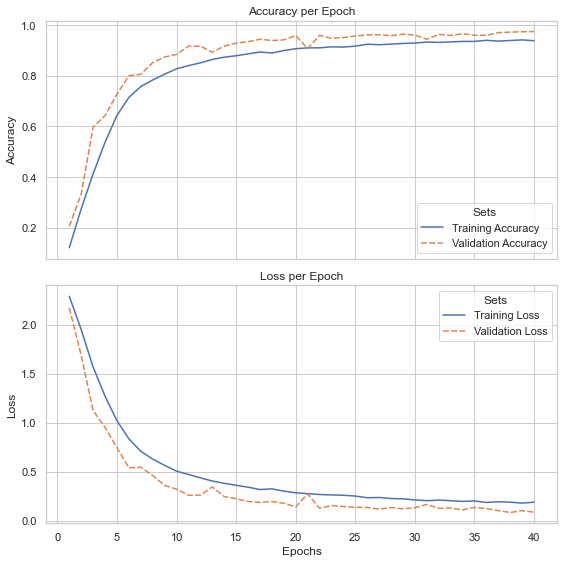

In [176]:
# Plot the results for the First Model
plotResults(history_first_model_pd)

***Even though it's a considerably simple CNN model with 5 Conv Layers followed by it's MaxPooling layers and two final Dense Layers, it achieves a 97.45% accuracy on the validation data.***

In [ ]:
# Load the First Model
# In case you want to run the predictions on the savedModel

first_model = tf.keras.models.load_model(os.path.join(project_folder, "first_model/40")

In [125]:
# Let's try to predict using the trained model and passing the Validation ImageDataGenerator
# so we can calculate some other metrics (ex.: Top-1, Top-5 accuracy, Confusion Matrix)

# First we need to create a new validation_generator_test without shuffling the data during test time
# We cannot reuse the previous generator because it has shuffle activated by default for training

validation_generator_test = validation_datagen.flow_from_directory(
    VALIDATION_DIR, target_size=(320, 240), batch_size=100, class_mode="categorical", shuffle=False)

Y_pred = first_model.predict(validation_generator_test)

Found 2237 images belonging to 10 classes.


In [126]:
# Then we convert the probabilities to a single integer that
# describes the predicted class 

Y_pred_converted = np.argmax(Y_pred, axis=1)
print("The Predictions shape is: ", Y_pred_converted.shape)
print("The True Labels shape is: ", validation_generator.labels.shape)

The Predictions shape is:  (2237,)
The True Labels shape is:  (2237,)


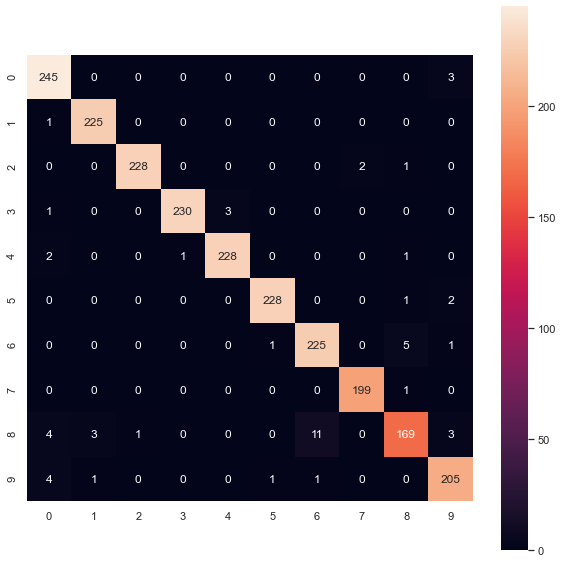

In [129]:
from sklearn.metrics import confusion_matrix

# Let's calculate the Confusion Matrix for our predictions on the Validation Set
cm = confusion_matrix(validation_generator.labels, Y_pred_converted)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', square=True)
plt.show()

In [132]:
# Let's calculate the Top-1 and Top-5 Accuracies
# We need to convert the Labels for the Validation DataImageGenerator into One Hot enconding

Y_true_one_hot = tf.one_hot(validation_generator.labels, depth = 10)

# Using Keras TopKCategoricalAccuracy function to Calculate the TOP-1 Accuracy
top1_first_model = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
top1_first_model.update_state(Y_true_one_hot, Y_pred)

# Using Keras TopKCategoricalAccuracy function to Calculate the TOP-5 Accuracy
top5_first_model = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
top5_first_model.update_state(Y_true_one_hot, Y_pred)

print("The First Model Top-1 Accuracy is: ", top1_first_model.result().numpy())
print("The First Model Top-5 Accuracy is: ", top5_first_model.result().numpy())

The First Model Top-1 Accuracy is:  0.9754135
The First Model Top-5 Accuracy is:  0.99910593


***After calculating some other metrics such as the Confusion Matrix, Top-1 and Top-5 Accuracies, we can notice that the model is performing considerably well in all of them!***

## 5) Let's now start playing with bigger models!

We're going to use some famous CNN architecures for image classification. 

### 5.1) Let's try some Transfer Learning first

We'll use an Inception V3 model from Tensorflow Hub to get a Feature Vector Extractor and then we add the final layers to match the 10 classes that we have.

In [139]:
import tensorflow_hub as hub

# The number of classes on our State Farm Dataset
num_classes = 10

# Let's use a Inception V3 model trained on ImageNet as our feature vector extractor
feature_extractor_model = (
    "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"
)

# We create a new model using the first
# Set trainable=False so we don't retrain the layers from Inception
# We just train our final output dense layer to predict between our 10 classes
inceptionV3_pretrained_model = tf.keras.Sequential(
    [
        hub.KerasLayer(feature_extractor_model, trainable=False),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)
inceptionV3_pretrained_model.build([None, 299, 299, 3])  # Batch input shape.
inceptionV3_pretrained_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [140]:
# Compile the model
inceptionV3_pretrained_model.compile(
    optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [141]:
# Creating a new flow_from_directory for the training data
# adjusting the input dimensions to 299x299
train_generator_inception = train_datagen.flow_from_directory(
    TRAINING_DIR, target_size=(299, 299), batch_size=100, class_mode="categorical"
)

# Creating a new flow_from_directory for the validation data
# adjusting the input dimensions to 299x299
validation_generator_inception = validation_datagen.flow_from_directory(
    VALIDATION_DIR, target_size=(299, 299), batch_size=100, class_mode="categorical"
)

Found 20187 images belonging to 10 classes.
Found 2237 images belonging to 10 classes.


In [142]:
history_inception = inceptionV3_pretrained_model.fit(
    train_generator_inception,
    epochs=10,
    verbose=1,
    validation_data=validation_generator_inception,
)

Epoch 1/10


2021-07-16 20:55:31.809153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


202/202 [==============================] - ETA: 0s - loss: 1.7703 - accuracy: 0.4087

2021-07-16 21:25:02.270883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


202/202 [==============================] - 1939s 10s/step - loss: 1.7703 - accuracy: 0.4087 - val_loss: 1.4306 - val_accuracy: 0.5472
Epoch 2/10
202/202 [==============================] - 2035s 10s/step - loss: 1.2830 - accuracy: 0.6032 - val_loss: 1.1230 - val_accuracy: 0.6853
Epoch 3/10
202/202 [==============================] - 2248s 11s/step - loss: 1.1143 - accuracy: 0.6510 - val_loss: 1.0435 - val_accuracy: 0.6956
Epoch 4/10
202/202 [==============================] - 1946s 10s/step - loss: 1.0077 - accuracy: 0.6833 - val_loss: 0.8974 - val_accuracy: 0.7515
Epoch 5/10
202/202 [==============================] - 1911s 9s/step - loss: 0.9417 - accuracy: 0.7063 - val_loss: 0.8492 - val_accuracy: 0.7702
Epoch 6/10
202/202 [==============================] - 1718s 9s/step - loss: 0.8709 - accuracy: 0.7303 - val_loss: 0.8128 - val_accuracy: 0.7667
Epoch 7/10
202/202 [==============================] - 1909s 9s/step - loss: 0.8254 - accuracy: 0.7444 - val_loss: 0.7686 - val_accuracy: 0.7702

In [143]:
# Let's save the inception model trained for 10 epochs
inceptionV3_pretrained_model.save(os.path.join(project_folder, "inceptionV3_pretrained_model/10"))

INFO:tensorflow:Assets written to: /Users/gil/Documents/Cursos/FourthBrain/Projects/State_Farm/inceptionV3_pretrained_model/10/assets


INFO:tensorflow:Assets written to: /Users/gil/Documents/Cursos/FourthBrain/Projects/State_Farm/inceptionV3_pretrained_model/10/assets


In [150]:
history_inception_2 = inceptionV3_pretrained_model.fit(
    train_generator_inception,
    epochs=40,
    verbose=1,
    validation_data=validation_generator_inception,
)

Epoch 1/40
202/202 [==============================] - 2240s 11s/step - loss: 0.7151 - accuracy: 0.7769 - val_loss: 0.6599 - val_accuracy: 0.8145
Epoch 2/40
202/202 [==============================] - 2729s 13s/step - loss: 0.6903 - accuracy: 0.7842 - val_loss: 0.6651 - val_accuracy: 0.8069
Epoch 3/40
202/202 [==============================] - 2590s 13s/step - loss: 0.6854 - accuracy: 0.7876 - val_loss: 0.6402 - val_accuracy: 0.8042
Epoch 4/40
202/202 [==============================] - 2378s 12s/step - loss: 0.6665 - accuracy: 0.7930 - val_loss: 0.6277 - val_accuracy: 0.8158
Epoch 5/40
202/202 [==============================] - 2199s 11s/step - loss: 0.6524 - accuracy: 0.7988 - val_loss: 0.5626 - val_accuracy: 0.8359
Epoch 6/40
202/202 [==============================] - 2254s 11s/step - loss: 0.6430 - accuracy: 0.7981 - val_loss: 0.5943 - val_accuracy: 0.8163
Epoch 7/40
202/202 [==============================] - 2291s 11s/step - loss: 0.6195 - accuracy: 0.8064 - val_loss: 0.5352 - val_ac

KeyboardInterrupt: 

In [151]:
inceptionV3_pretrained_model.save(os.path.join(project_folder, "inceptionV3_pretrained_model/28"))

INFO:tensorflow:Assets written to: /Users/gil/Documents/Cursos/FourthBrain/Projects/State_Farm/inceptionV3_pretrained_model/28/assets


INFO:tensorflow:Assets written to: /Users/gil/Documents/Cursos/FourthBrain/Projects/State_Farm/inceptionV3_pretrained_model/28/assets


In [169]:
# Since I manually interrupted the second training of the InceptionV3 model
# I'll have to manually load the history data for that training
# Should use Keras Callbacks in the next implementation to avoid this problem
# and to also save the model at each epoch.

history_inception_2_pd = pd.read_csv(os.path.join(project_folder, "inceptionV3_history_2.csv"), sep=";")
history_inception_2_pd.head()

,Epochs,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
0,11,0.7769,0.8145,0.7151,0.6599
1,12,0.7842,0.8069,0.6903,0.6651
2,13,0.7876,0.8042,0.6854,0.6402
3,14,0.7930,0.8158,0.6665,0.6277
4,15,0.7988,0.8359,0.6524,0.5626


In [170]:
# Get the results on the training and validation data sets
# for the first training session for the inceptionV3 model
results_inceptionV3_pretrained_model_1 = np.vstack(
    (
        history_inception.history["accuracy"],
        history_inception.history["val_accuracy"],
        history_inception.history["loss"],
        history_inception.history["val_loss"],
    )
).T

# Create a Panda Dataframe from the results of the first training
# session for the inceptionV3 Model

history_inception_1_pd = pd.DataFrame(
    {
        "Epochs": range(1, results_inceptionV3_pretrained_model_1.shape[0] + 1),
        "Training Accuracy": results_inceptionV3_pretrained_model_1[:, 0],
        "Validation Accuracy": results_inceptionV3_pretrained_model_1[:, 1],
        "Training Loss": results_inceptionV3_pretrained_model_1[:, 2],
        "Validation Loss": results_inceptionV3_pretrained_model_1[:, 3],
    }
)

In [178]:
# Let's now concatenate both Dataframes for both training sessions

history_inception_pd = pd.concat([history_inception_1_pd, history_inception_2_pd])
history_inception_pd.tail()

,Epochs,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss
23,34,0.8408,0.8328,0.5050,0.5027
24,35,0.8377,0.8538,0.5046,0.4655
25,36,0.8406,0.8561,0.5026,0.4471
26,37,0.8393,0.8637,0.5048,0.4475
27,38,0.8460,0.8525,0.4943,0.4682


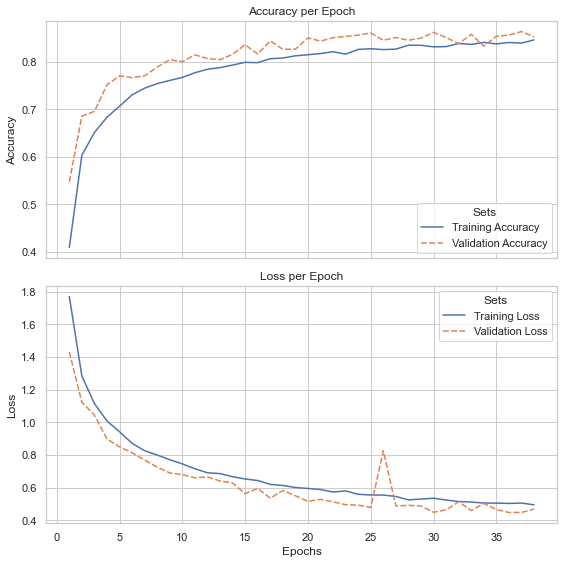

In [177]:
plotResults(history_inception_pd)

***Training for a total of 38 Epochs got us an Validation Accuracy of 85% which is quite less than the simple First Model but since the training was taking to long I decided to stop and check the model performance on the other metrics as well (Confusion Matrix, Top-5 Accuracy).***

In [ ]:
# Load the InceptionV3 Model
# In case you want to run the predictions on the savedModel (total of 38 Epochs Trained)

inceptionV3_pretrained_model = tf.keras.models.load_model(os.path.join(project_folder, "inceptionV3_pretrained_model/28")

In [179]:
# Let's now run some prediction on the InceptionV3 model

Y_pred_inception = inceptionV3_pretrained_model.predict(validation_generator_test)

2021-07-18 20:07:18.346908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [183]:
# Then we convert the probabilities to a single integer that
# describes the predicted class 

Y_pred_inception_converted = np.argmax(Y_pred_inception, axis=1)
print("The Predictions shape is: ", Y_pred_inception_converted.shape)
print("The True Labels shape is: ", validation_generator.labels.shape)

The Predictions shape is:  (2237,)
The True Labels shape is:  (2237,)


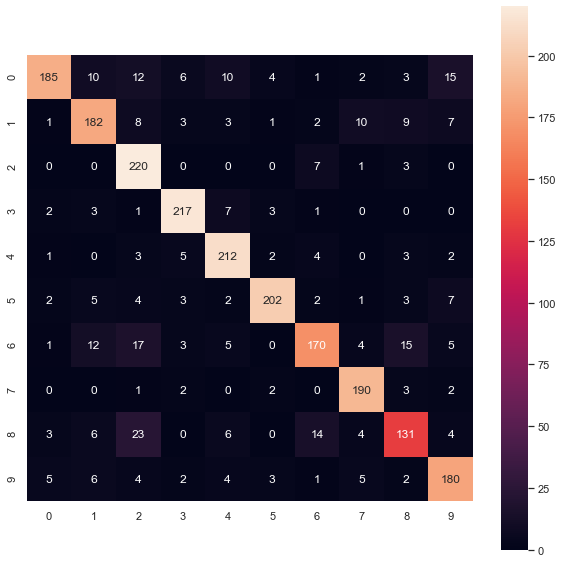

In [184]:
# Let's calculate the Confusion Matrix for our predictions on the Validation Set
cm = confusion_matrix(validation_generator.labels, Y_pred_inception_converted)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', square=True)
plt.show()

In [185]:
# Let's calculate the Top-1 and Top-5 Accuracies

# Using Keras TopKCategoricalAccuracy function to Calculate the TOP-1 Accuracy
top1_inceptionV3_model = tf.keras.metrics.TopKCategoricalAccuracy(k=1)
top1_inceptionV3_model.update_state(Y_true_one_hot, Y_pred_inception)

# Using Keras TopKCategoricalAccuracy function to Calculate the TOP-5 Accuracy
top5_inceptionV3_model = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
top5_inceptionV3_model.update_state(Y_true_one_hot, Y_pred_inception)

print("The First Model Top-1 Accuracy is: ", top1_inceptionV3_model.result().numpy())
print("The First Model Top-5 Accuracy is: ", top5_inceptionV3_model.result().numpy())

The First Model Top-1 Accuracy is:  0.8444345
The First Model Top-5 Accuracy is:  0.9919535


## Predictions on Real Kaggle Test Data

Let's now run predictions on both models for the real Test Set so we can submit them to Kaggle and compare the results.

In [195]:
# Creating the ImageDataGenerator for the test data for the first model
testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
testing_generator_first_model = testing_datagen.flow_from_directory(
    TESTING_DIR, target_size=(320, 240), batch_size=100, class_mode=None, shuffle=False
)

Found 79726 images belonging to 1 classes.


In [196]:
# Let's predict for the Test set
Y_pred_test_first_model = first_model.predict(testing_generator_first_model)

2021-07-18 22:38:51.972855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [202]:
#print(Y_pred_test_first_model[:10])
#print(testing_generator_first_model.filenames[:100])
test_first_model_pd = 

['test/img_1.jpg', 'test/img_10.jpg', 'test/img_100.jpg', 'test/img_1000.jpg', 'test/img_100000.jpg', 'test/img_100001.jpg', 'test/img_100002.jpg', 'test/img_100003.jpg', 'test/img_100004.jpg', 'test/img_100005.jpg', 'test/img_100007.jpg', 'test/img_100008.jpg', 'test/img_100009.jpg', 'test/img_10001.jpg', 'test/img_100010.jpg', 'test/img_100011.jpg', 'test/img_100012.jpg', 'test/img_100013.jpg', 'test/img_100014.jpg', 'test/img_100016.jpg', 'test/img_100017.jpg', 'test/img_100018.jpg', 'test/img_100019.jpg', 'test/img_10002.jpg', 'test/img_100020.jpg', 'test/img_100022.jpg', 'test/img_100023.jpg', 'test/img_100024.jpg', 'test/img_100025.jpg', 'test/img_100028.jpg', 'test/img_100030.jpg', 'test/img_100031.jpg', 'test/img_100032.jpg', 'test/img_100033.jpg', 'test/img_100034.jpg', 'test/img_100035.jpg', 'test/img_100037.jpg', 'test/img_100038.jpg', 'test/img_100039.jpg', 'test/img_10004.jpg', 'test/img_100040.jpg', 'test/img_100042.jpg', 'test/img_100043.jpg', 'test/img_100044.jpg', 'tes